In [ ]:
import numpy as np
from numpy.linalg import solve
import matplotlib.pyplot as plt

DTYPE = np.float64
def soft_threshold(x, tau):
    return np.sign(x) * np.maximum(np.abs(x) - tau, 0.0)

def soft_threshold_box(x, tau, u_max):
    u = soft_threshold(x, tau)
    return np.clip(u, -u_max, u_max)

# Data helpers
def sample_mixture(means, covs, weights, n, rng):
    k = len(weights); w = np.asarray(weights, dtype=DTYPE)/np.sum(weights)
    idx = rng.choice(k, size=n, p=w)
    X = np.zeros((n,2), dtype=DTYPE)
    for j in range(k):
        nj = int(np.sum(idx==j))
        if nj:
            X[idx==j] = rng.multivariate_normal(means[j], covs[j], nj).astype(DTYPE)
    return X

def fit_data_scale(X0, Y):
    # robust joint scale for linear features
    XY = np.vstack([X0, Y])
    s = np.median(np.abs(XY - np.median(XY, axis=0)), axis=0)  # MAD
    s[s<1e-3] = 1.0
    return s

def rbf_features(X, centers, sigma, scale_lin):
    # \Phi = [1, (x/scale_lin), (y/scale_lin), RBF...]
    Xs = X / scale_lin
    n, m = X.shape[0], centers.shape[0]
    Phi = np.ones((n, 3+m), dtype=DTYPE)
    Phi[:,1:3] = Xs
    if m:
        diff = (X[:,None,:] - centers[None,:,:])
        Phi[:,3:] = np.exp(-np.sum(diff**2, axis=2)/(2*sigma**2))
    return Phi

def rbf_grad(X, centers, sigma, scale_lin):
    n, m = X.shape[0], centers.shape[0]
    Gx = np.zeros((n, 3+m), dtype=DTYPE); Gy = np.zeros((n, 3+m), dtype=DTYPE)
    # d/dx of [1, x/sx, y/sy] is [0, 1/sx, 0]; for y same with 1/sy
    Gx[:,1] = 1.0/scale_lin[0]; Gy[:,2] = 1.0/scale_lin[1]
    if m:
        diff = (X[:,None,:] - centers[None,:,:])              # (n,m,2)
        R = np.exp(-np.sum(diff**2, axis=2)/(2*sigma**2))     # (n,m)
        Gx[:,3:] = -(diff[:,:,0]/(sigma**2)) * R
        Gy[:,3:] = -(diff[:,:,1]/(sigma**2)) * R
    return Gx, Gy

# # KDE log-density and score (bounded exponent => no overflow)
# def kde_log_p(x, ref, sigma):
#     diff = x[:,None,:] - ref[None,:,:]
#     d2 = np.sum(diff**2, axis=2)
#     M = ref.shape[0]
#     s = np.exp(-d2/(2*sigma**2)).mean(axis=1) + 1e-300  # avoid log(0)
#     const = -np.log(2*np.pi*sigma**2)
#     return np.log(s) + const

# def kde_score(x, ref, sigma):
#     diff = x[:,None,:] - ref[None,:,:]
#     w = np.exp(-np.sum(diff**2, axis=2)/(2*sigma**2))
#     Z = np.sum(w, axis=1, keepdims=True) + 1e-300
#     num = (w[:,:,None] * diff).sum(axis=1)
#     return - num / (sigma**2 * Z)

def mmd2_rbf(X, Y, sigma):
    n, m = X.shape[0], Y.shape[0]
    XX = np.sum((X[:,None,:]-X[None,:,:])**2, axis=2)   # (n,n)
    YY = np.sum((Y[:,None,:]-Y[None,:,:])**2, axis=2)   # (m,m)
    XY = np.sum((X[:,None,:]-Y[None,:,:])**2, axis=2)   # (n,m)
    kXX = np.exp(-XX/(2*sigma**2))
    kYY = np.exp(-YY/(2*sigma**2))
    kXY = np.exp(-XY/(2*sigma**2))
    return kXX.mean() + kYY.mean() - 2.0*kXY.mean()

def grad_mmd2_rbf_wrt_X(X, Y, sigma):
    n, m = X.shape[0], Y.shape[0]
    diff_xx = X[:,None,:] - X[None,:,:]                  # (n,n,2)
    Kxx = np.exp(-np.sum(diff_xx**2, axis=2)/(2*sigma**2))
    Gxx = (diff_xx * Kxx[:,:,None]).sum(axis=1) * (2.0/(sigma**2 * n**2))
    diff_xy = X[:,None,:] - Y[None,:,:]                  # (n,m,2)
    Kxy = np.exp(-np.sum(diff_xy**2, axis=2)/(2*sigma**2))
    Gxy = (diff_xy * Kxy[:,:,None]).sum(axis=1) * (2.0/(sigma**2 * n * m))
    return Gxx - Gxy * 2.0

# driver (box-constrained)
def optimal_u_and_driver(Z, eps, lam, u_max):
    arg = -np.sqrt(eps) * Z
    u_star = soft_threshold_box(arg, eps*lam, u_max)
    quad = (0.5/eps) * np.sum(u_star*u_star, axis=1)
    l1   = lam * np.sum(np.abs(u_star), axis=1)
    cross= (1.0/np.sqrt(eps)) * np.sum(Z * u_star, axis=1)
    h = quad + l1 + cross
    u_star = np.nan_to_num(u_star, nan=0.0, posinf=u_max, neginf=-u_max)
    h      = np.nan_to_num(h, nan=1e6, posinf=1e6, neginf=1e6)
    return u_star, h

# solver
def solve_sparse_sb_fbsde_safe(
    pi0_params, pi1_params,
    n_particles=4000, T=32, eps=0.5, lam=0.6, u_max=3.0,
    beta=250.0, mmd_sigma=2.0,
    basis_m=128, basis_sigma=2.0, ridge=5e-3,
    outer_loops=30, eta=0.5, seed=7
):
    rng = np.random.default_rng(seed); dt = 1.0/T

    # define source and target distributions
    means0 = [p[1] for p in pi0_params]
    covs0  = [p[2] for p in pi0_params]
    w0     = [p[0] for p in pi0_params]
    means1 = [p[1] for p in pi1_params]
    covs1  = [p[2] for p in pi1_params]
    w1     = [p[0] for p in pi1_params]

    X0 = sample_mixture(means0, covs0, w0, n_particles, rng)
    Yt = sample_mixture(means1, covs1, w1, n_particles, rng)

    # feature scaling for linear part
    scale_lin = fit_data_scale(X0, Yt)

    # basis centers
    centers = Yt[rng.integers(low=0, high=Yt.shape[0], size=basis_m)]

    # warm-start nominal drift using MMD gradient (sparse, then clipped)
    grad_mmd0 = beta * grad_mmd2_rbf_wrt_X(X0, Yt, mmd_sigma)
    u0 = soft_threshold_box(-eps*grad_mmd0, eps*lam, u_max)

    Phi0 = rbf_features(X0, centers, basis_sigma, scale_lin)
    A0 = Phi0.T @ Phi0 + ridge*np.eye(Phi0.shape[1])
    thx = [solve(A0, Phi0.T @ u0[:,0])] * T
    thy = [solve(A0, Phi0.T @ u0[:,1])] * T

    logs = []
    for it in range(outer_loops):
        # forward
        X = np.zeros((T+1, n_particles, 2), dtype=DTYPE); X[0] = X0
        K = np.zeros((T, n_particles, 2), dtype=DTYPE)
        for i in range(T):
            Phi = rbf_features(X[i], centers, basis_sigma, scale_lin)
            u_nom = np.c_[Phi@thx[i], Phi@thy[i]]
            u_nom = np.clip(u_nom, -u_max, u_max)
            K[i]  = u_nom / np.sqrt(eps)
            dW    = rng.normal(size=(n_particles,2)).astype(DTYPE) * np.sqrt(dt)
            X[i+1]= X[i] + u_nom*dt + np.sqrt(eps)*dW

        # terminal values: per-sample contribution of β·MMD²
        XT = X[T]
        XX = np.sum((XT[:,None,:]-XT[None,:,:])**2, axis=2)
        XY = np.sum((XT[:,None,:]-Yt[None,:,:])**2, axis=2)
        kXX_row = np.exp(-XX/(2*mmd_sigma**2)).mean(axis=1)
        kXY_row = np.exp(-XY/(2*mmd_sigma**2)).mean(axis=1)
        gN = beta * (kXX_row - 2.0*kXY_row)

        # backward (LSMC)
        Y = np.zeros((T+1, n_particles), dtype=DTYPE)
        Z = np.zeros((T+1, n_particles, 2), dtype=DTYPE)
        Y[T] = gN
        # Initialize terminal gradient
        dMMD_T = beta * grad_mmd2_rbf_wrt_X(XT, Yt, mmd_sigma)
        Z[T]   = np.sqrt(eps) * dMMD_T
        Z[T]   = np.clip(np.nan_to_num(Z[T], nan=0.0, posinf=1e3, neginf=-1e3), -1e3, 1e3)

        for i in reversed(range(T)):
            Z_p1 = Z[i+1]
            
            # control and driver
            u_star, h = optimal_u_and_driver(Z_p1, eps, lam, u_max)
            
            # Importance-sampling correction at the SAME time-point:
            Phi_p1    = rbf_features(X[i+1], centers, basis_sigma, scale_lin)
            idx       = min(i+1, T-1)
            u_nom_p1  = np.c_[Phi_p1 @ thx[idx], Phi_p1 @ thy[idx]]
            u_nom_p1  = np.clip(u_nom_p1, -u_max, u_max)
            K_p1      = u_nom_p1 / np.sqrt(eps)
            h         = h - np.sum(Z_p1 * K_p1, axis=1)
            
            Y_hat = Y[i+1] + h*dt
            Phi_i = rbf_features(X[i], centers, basis_sigma, scale_lin)
            A = Phi_i.T @ Phi_i + ridge*np.eye(Phi_i.shape[1])
            alpha = solve(A, Phi_i.T @ Y_hat)
            Y[i] = Phi_i @ alpha
            
            Gx_i, Gy_i = rbf_grad(X[i], centers, basis_sigma, scale_lin)
            Z[i,:,0] = np.sqrt(eps) * (Gx_i @ alpha)
            Z[i,:,1] = np.sqrt(eps) * (Gy_i @ alpha)
            
            Z[i] = np.clip(np.nan_to_num(Z[i], nan=0.0, posinf=1e3, neginf=-1e3), -1e3, 1e3)

        # policy improvement
        quad = 0.0; l1 = 0.0
        for i in range(T):
            u_star_i, _ = optimal_u_and_driver(Z[i], eps, lam, u_max)
            Phi_i = rbf_features(X[i], centers, basis_sigma, scale_lin)
            A = Phi_i.T @ Phi_i + ridge*np.eye(Phi_i.shape[1])
            theta_x_new = solve(A, Phi_i.T @ u_star_i[:,0])
            theta_y_new = solve(A, Phi_i.T @ u_star_i[:,1])
            
            thx[i] = (1-eta)*thx[i] + eta*theta_x_new
            thy[i] = (1-eta)*thy[i] + eta*theta_y_new
            
            quad += (0.5/eps) * np.mean(np.sum(u_star_i*u_star_i, axis=1)) * dt
            l1   += lam * np.mean(np.sum(np.abs(u_star_i), axis=1)) * dt

        
        term = float(beta * mmd2_rbf(X[T], Yt, mmd_sigma))
        total = float(quad + l1 + term)
        logs.append((total, quad, l1, term))
        if (it+1) % max(1, outer_loops//10) == 0:
            print(f"[outer {it+1}/{outer_loops}] total={total:.4f} quad={quad:.4f} l1={l1:.4f} term={term:.4f}")

    return X0, Yt, thx, thy, centers, scale_lin, logs, (eps, T, basis_sigma, u_max)

[geom] s=[0. 0.], A=[0. 4.], D=[4. 0.]
       Δ_axis=[0. 4.], |Δ_axis|_1=4.000, ||Δ_axis||^2=16.000
       Δ_diag=[4. 0.], |Δ_diag|_1=4.000, ||Δ_diag||^2=16.000
       S_axis - S_diag = λ*(+0.0) + +0.000  (function of λ)
       λ* (flip) = inf  -> for eps=0.6, expected flip at λ* = 3.333 in this setup


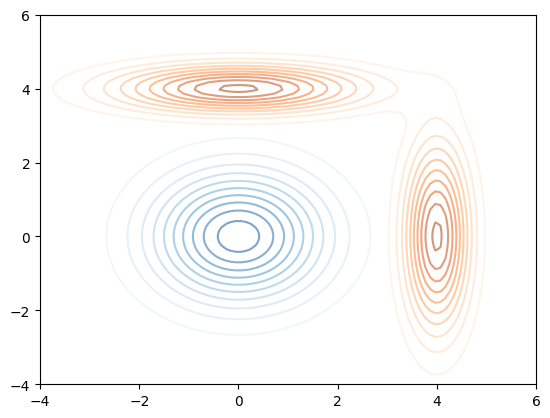

In [ ]:
# Compute density at x for a mixture
def mixture_density(x, dist_params):
    dens = np.zeros(x.shape[0])
    for w, mean, cov in dist_params:
        diff = np.array(x - mean)
        inv_cov = np.linalg.inv(cov)
        det_cov = np.linalg.det(cov)
        norm_const = 1.0 / (2 * np.pi * np.sqrt(det_cov))
        exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
        dens += w * norm_const * np.exp(exponent)
    return dens

mean0 = np.array([0.0,  0.0])
cov0  = np.diag([1.5, 1.5])
means0 = [mean0]; covs0 = [cov0]; w0 = [1.0]

means1 = [np.array([ 0.0,  4.0]),
          np.array([ 4.0,  0.0])]
covs1  = [np.diag([3.0,0.2]), np.diag([0.2,3.0])]
w1     = [0.5, 0.5]

pi0_params = [(w0[0], means0[0], cov0)]
pi1_params = [(w1[0], means1[0], covs1[0]),
              (w1[1], means1[1], covs1[1])]

# draw contours of source and target
x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
Z, Y = np.meshgrid(x, y)
grid_points = np.stack([Z.ravel(), Y.ravel()], axis=1)
pi0_density = mixture_density(grid_points, pi0_params).reshape(Z.shape)
pi1_density = mixture_density(grid_points, pi1_params).reshape(Z.shape)

plt.contour(Z, Y, pi0_density, levels=10, cmap='Blues', alpha=0.5)
plt.contour(Z, Y, pi1_density, levels=10, cmap='Oranges', alpha=0.5)
plt.xlim(-4, 6)
plt.ylim(-4, 6)
plt.show()

[outer 1/15] total=140.2979 quad=44.6633 l1=44.4093 term=51.2253
[outer 2/15] total=104.4249 quad=30.9808 l1=35.3133 term=38.1307
[outer 3/15] total=80.0912 quad=22.9155 l1=28.9860 term=28.1897
[outer 4/15] total=61.0996 quad=16.2061 l1=23.2694 term=21.6241
[outer 5/15] total=47.5783 quad=11.2883 l1=18.6620 term=17.6280
[outer 6/15] total=43.3194 quad=9.8445 l1=17.6164 term=15.8586
[outer 7/15] total=38.8402 quad=8.3931 l1=15.7459 term=14.7012
[outer 8/15] total=38.3483 quad=8.4772 l1=16.1346 term=13.7365
[outer 9/15] total=34.0250 quad=7.1549 l1=14.1626 term=12.7075
[outer 10/15] total=33.1412 quad=7.0008 l1=14.1716 term=11.9688
[outer 11/15] total=33.2790 quad=6.9851 l1=13.7784 term=12.5156
[outer 12/15] total=29.9448 quad=5.7403 l1=12.4945 term=11.7099
[outer 13/15] total=29.7218 quad=5.8296 l1=12.1908 term=11.7013
[outer 14/15] total=30.8110 quad=6.2462 l1=13.0145 term=11.5503
[outer 15/15] total=28.4202 quad=5.3653 l1=11.9275 term=11.1275


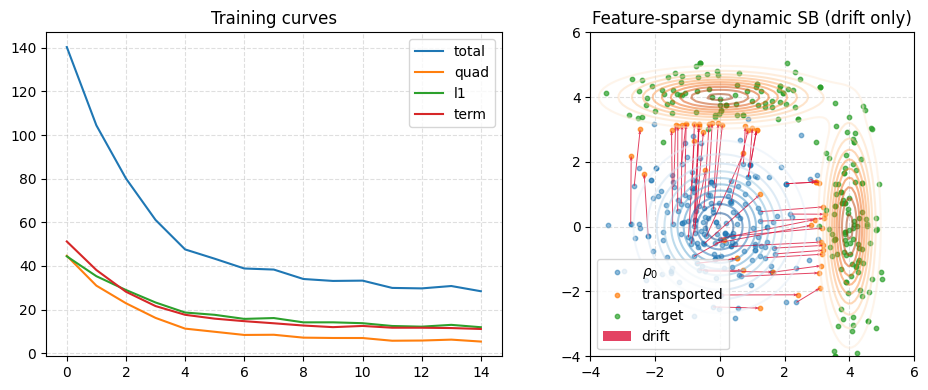

In [ ]:
X0, Yt, thx, thy, centers, scale_lin, logs, cfg = solve_sparse_sb_fbsde_safe(
    pi0_params=pi0_params, pi1_params=pi1_params,
    n_particles=1000,
    T=56,
    eps=0.5,
    lam=6.0,
    u_max=7.0,
    beta=100.0,
    mmd_sigma=2.4,
    basis_m=160, basis_sigma=1.7,
    ridge=4e-2,
    outer_loops=15,
    eta=0.12,
    seed=7
)

eps, T, basis_sigma, u_max = cfg
dt = 1.0/T
def u_nom(x, i):
    Phi = rbf_features(x, centers, basis_sigma, scale_lin)
    u = np.c_[Phi@thx[i], Phi@thy[i]]
    return np.clip(u, -u_max, u_max)

# drift-only map
X = X0.copy()
for i in range(T):
    X = X + u_nom(X, i)*dt

# plots
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot([v[0] for v in logs], label="total")
ax[0].plot([v[1] for v in logs], label="quad")
ax[0].plot([v[2] for v in logs], label="l1")
ax[0].plot([v[3] for v in logs], label="term")
ax[0].grid(ls='--', alpha=0.4); ax[0].legend(); ax[0].set_title("Training curves")

idx = np.random.default_rng(0).integers(0, X0.shape[0], 200)
idx_transport = np.random.default_rng(0).integers(0, X0.shape[0], 50)
ax[1].scatter(X0[idx,0], X0[idx,1], s=10, label=r"$\rho_0$", alpha=0.5)
ax[1].scatter(X[idx_transport,0],  X[idx_transport,1],  s=10, label="transported", alpha=0.7)
ax[1].scatter(Yt[idx,0], Yt[idx,1], s=10, label="target", alpha=0.7)
ax[1].quiver(X0[idx_transport,0], X0[idx_transport,1], X[idx_transport,0]-X0[idx_transport,0], X[idx_transport,1]-X0[idx_transport,1],
                angles='xy', scale_units='xy', scale=1.0, width=0.003, color='crimson', alpha=0.8, label="drift")
ax[1].set_aspect('equal', 'box'); ax[1].legend(); ax[1].grid(ls='--', alpha=0.4)
ax[1].set_title("Feature-sparse dynamic SB (drift only)")
ax[1].contour(Z, Y, pi0_density, levels=10, cmap='Blues', alpha=0.5)
ax[1].contour(Z, Y, pi1_density, levels=10, cmap='Oranges', alpha=0.5)
ax[1].set_xlim(-4, 6)
ax[1].set_ylim(-4, 6)
ax[1].legend(loc='lower left')

plt.tight_layout()
plt.show()

[outer 1/15] total=181.2736 quad=76.1112 l1=0.0000 term=105.1624
[outer 2/15] total=146.6798 quad=67.6913 l1=0.0000 term=78.9885
[outer 3/15] total=118.8136 quad=56.0539 l1=0.0000 term=62.7597
[outer 4/15] total=92.6506 quad=46.8731 l1=0.0000 term=45.7774
[outer 5/15] total=70.7319 quad=38.3619 l1=0.0000 term=32.3700
[outer 6/15] total=51.3173 quad=29.6597 l1=0.0000 term=21.6576
[outer 7/15] total=43.3593 quad=25.3966 l1=0.0000 term=17.9627
[outer 8/15] total=37.2705 quad=23.1194 l1=0.0000 term=14.1511
[outer 9/15] total=34.1616 quad=21.8963 l1=0.0000 term=12.2654
[outer 10/15] total=27.5099 quad=17.9227 l1=0.0000 term=9.5872
[outer 11/15] total=28.3068 quad=18.0926 l1=0.0000 term=10.2142
[outer 12/15] total=23.9957 quad=15.1113 l1=0.0000 term=8.8844
[outer 13/15] total=22.8391 quad=14.2423 l1=0.0000 term=8.5968
[outer 14/15] total=23.8355 quad=15.3681 l1=0.0000 term=8.4674
[outer 15/15] total=21.6285 quad=13.7494 l1=0.0000 term=7.8791
[outer 1/15] total=186.9159 quad=73.2218 l1=11.243

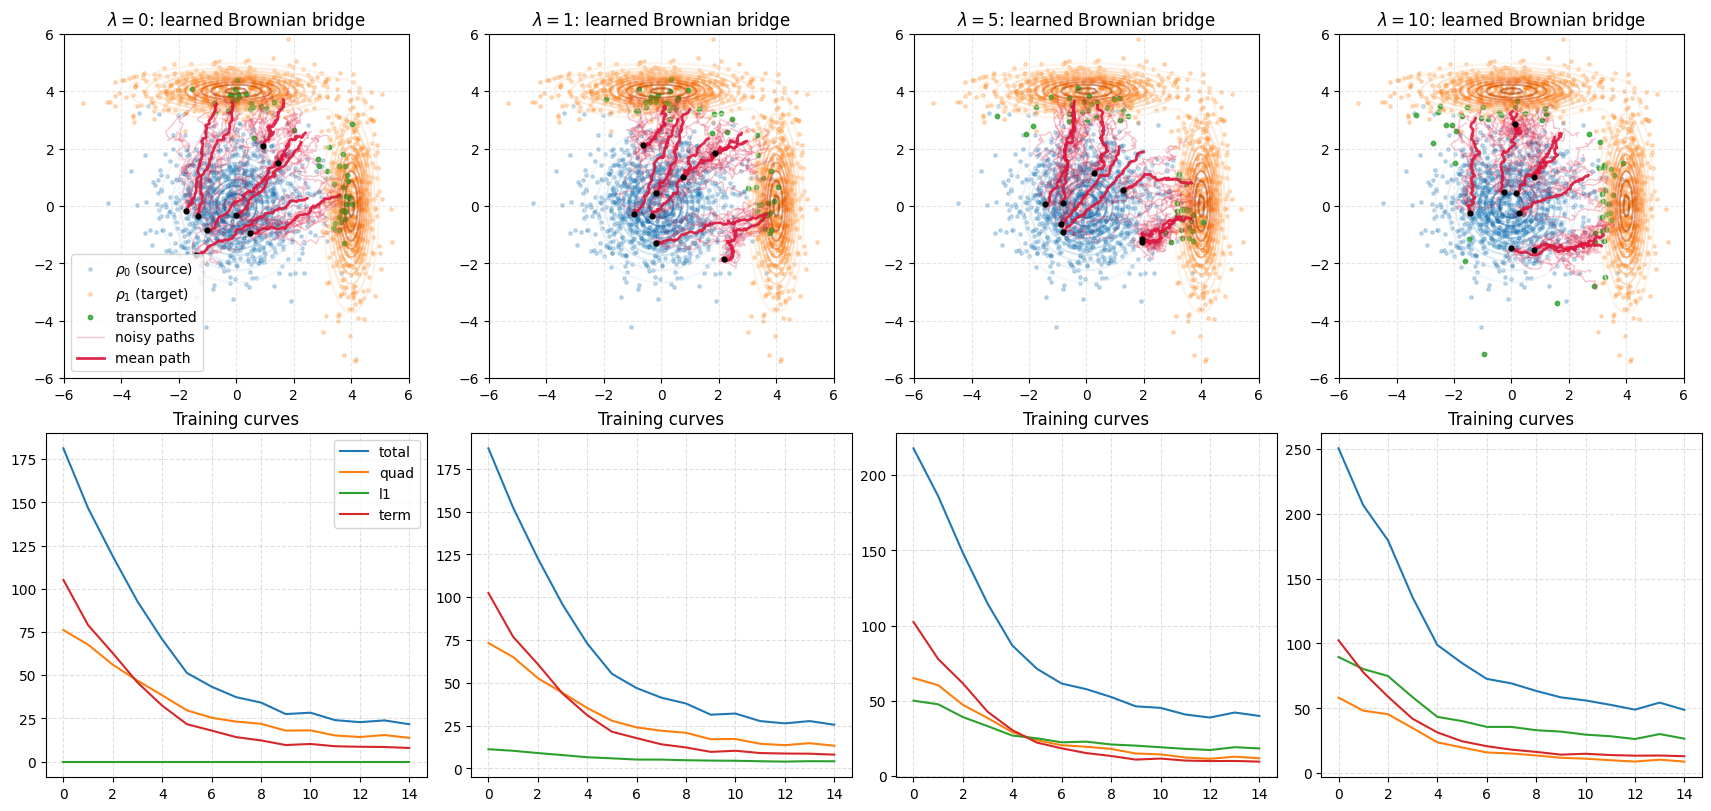

In [ ]:
# learned policy and stochastic rollout for bridge
def u_nom_fn(thx, thy, centers, basis_sigma, scale_lin, u_max):
    def u_nom(x, i):
        Phi = rbf_features(x, centers, basis_sigma, scale_lin)
        u = np.c_[Phi @ thx[i], Phi @ thy[i]]
        return np.clip(u, -u_max, u_max)
    return u_nom

def rollout_bridge(X0, T, eps, u_nom, n_paths_all=1500, rng=None):
    """Roll out the learned bridge for all particles with noise."""
    if rng is None: rng = np.random.default_rng(123)
    dt = 1.0 / T
    X = X0.copy()
    for j in range(T):
        dW = rng.normal(size=X.shape) * np.sqrt(dt)
        X = X + u_nom(X, j) * dt + np.sqrt(eps) * dW
    return X

def spaghetti_paths(X0, T, eps, u_nom, n_starts=8, K=6, rng=None):
    """Pick n_starts initial points; for each, simulate K noisy paths (and mean)."""
    if rng is None: rng = np.random.default_rng(456)
    dt = 1.0 / T
    idx = rng.choice(X0.shape[0], size=n_starts, replace=False)
    starts = X0[idx]
    paths = []   # list of arrays (K, T+1, 2)
    means = []   # list of arrays (T+1, 2)
    for s in starts:
        sims = np.zeros((K, T+1, 2), dtype=np.float64)
        for k in range(K):
            x = s.copy()[None, :]
            sims[k,0] = s
            for j in range(T):
                dW = rng.normal(size=(1,2)) * np.sqrt(dt)
                x = x + u_nom(x, j) * dt + np.sqrt(eps) * dW
                sims[k, j+1] = x[0]
        paths.append(sims)
        means.append(sims.mean(axis=0))
    return starts, paths, means

# sweep lambdas and plot bridges + training curves
fig, ax = plt.subplots(2, 4, figsize=(17, 8), constrained_layout=True)
lam_grid = [0, 1, 5, 10]

for col, lam in enumerate(lam_grid):
    X0, Yt, thx, thy, centers, scale_lin, logs, cfg = solve_sparse_sb_fbsde_safe(
        pi0_params=pi0_params, pi1_params=pi1_params,
        n_particles=1000,
        T=56,
        eps=0.5,
        lam=lam,
        u_max=7.0,
        beta=200.0,
        mmd_sigma=2.4,
        basis_m=160, basis_sigma=1.7,
        ridge=4e-2,
        outer_loops=15,
        eta=0.12,
        seed=7
    )
    eps, T, basis_sigma, u_max = cfg
    u_nom = u_nom_fn(thx, thy, centers, basis_sigma, scale_lin, u_max)

    rng_panel = np.random.default_rng(1000 + col)
    X_T_cloud = rollout_bridge(X0, T, eps, u_nom, rng=rng_panel)
    starts, paths, means = spaghetti_paths(X0, T, eps, u_nom, n_starts=8, K=6, rng=rng_panel)

    ax[0, col].contour(Z, Y, pi0_density, levels=10, cmap='Blues', alpha=0.45)
    ax[0, col].contour(Z, Y, pi1_density, levels=10, cmap='Oranges', alpha=0.55)
    ax[0, col].scatter(X0[:,0], X0[:,1], s=6, alpha=0.25, label=r"$\rho_0$ (source)")
    ax[0, col].scatter(Yt[:,0], Yt[:,1], s=6, alpha=0.25, label=r"$\rho_1$ (target)")

    idx_cloud = rng_panel.choice(X_T_cloud.shape[0], size=50, replace=False)
    ax[0, col].scatter(X_T_cloud[idx_cloud,0], X_T_cloud[idx_cloud,1],
                       s=10, alpha=0.8, label="transported")

    legend_done = False
    mean_legend_done = False
    for s, sims, mpath in zip(starts, paths, means):
        for k in range(sims.shape[0]):
            if not legend_done:
                ax[0, col].plot(sims[k,:,0], sims[k,:,1], lw=1.0, alpha=0.25, color='crimson', label="noisy paths")
                legend_done = True
            else:
                ax[0, col].plot(sims[k,:,0], sims[k,:,1], lw=1.0, alpha=0.25, color='crimson')
        if not mean_legend_done:
            ax[0, col].plot(mpath[:,0], mpath[:,1], lw=2.0, alpha=0.9, color='crimson', label="mean path")  # mean path
            mean_legend_done = True
        else:
            ax[0, col].plot(mpath[:,0], mpath[:,1], lw=2.0, alpha=0.9, color='crimson')
        ax[0, col].scatter([s[0]], [s[1]], c='k', s=12, zorder=3)

    ax[0, col].set_aspect('equal', 'box')
    ax[0, col].grid(ls='--', alpha=0.3)
    ax[0, col].set_xlim(-6, 6); ax[0, col].set_ylim(-6, 6)
    ax[0, col].set_title(fr"$\lambda={lam}$: learned Brownian bridge")

    if col == 0:
        ax[0, col].legend(loc='lower left')

    # training curves
    ax[1, col].plot([v[0] for v in logs], label="total")
    ax[1, col].plot([v[1] for v in logs], label="quad")
    ax[1, col].plot([v[2] for v in logs], label="l1")
    ax[1, col].plot([v[3] for v in logs], label="term")
    ax[1, col].grid(ls='--', alpha=0.4)
    ax[1, col].set_title("Training curves")
    if col == 0:
        ax[1, col].legend()

plt.show()